# 流变性能预测 - 基于物理信息神经网络（PINN）的实现

本笔记本使用物理信息神经网络（Physics-Informed Neural Networks, PINN）来预测高分子材料的流变性能。相比传统的机器学习方法，PINN具有以下优势：

1. 结合物理约束：
   - Cox-Merz规则
   - Kramers-Kronig关系
   - 储能损耗角物理约束
   - 热力学约束

2. 改进的特征工程：
   - WLF（Williams-Landel-Ferry）时温等效性
   - 考虑分子量和温度的耦合效应
   - 长宽比的非线性效应

3. 不确定性量化：
   - 使用深度集成和Monte Carlo Dropout
   - 提供预测的置信区间

In [4]:
# 导入所需的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from typing import Tuple, List

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子以确保可重复性
RANDOM_SEED = 24
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    
# 设置全局参数
BATCH_SIZE = 64        # 增大批次大小
LEARNING_RATE = 5e-4   # 调整学习率
EPOCHS = 1000          # 增加训练轮数
PHYSICS_WEIGHT = 0.01  # 降低物理约束权重
MC_SAMPLES = 50        # Monte Carlo采样次数

使用设备: cpu


In [5]:
# 数据加载和预处理
class RheologyDataset:
    def __init__(self, csv_path: str):
        """初始化数据集类
        
        Args:
            csv_path: PB_Data.csv的路径
        """
        # 读取数据
        self.df = pd.read_csv(csv_path)
        self.process_data()
        
    def process_data(self):
        """数据预处理和特征工程"""
        df = self.df
        
        # 基本特征工程
        df['aspect_ratio'] = df['Length_nm'] / df['Width_nm']
        df['log_freq'] = np.log10(df['Freq_rad_s'])
        
        # 新增: 材料特征计算
        df['PDI'] = df['Mw'] / df['Mn'] if 'PDI' not in df.columns else df['PDI']
        df['tan_delta'] = df['G2_Pa'] / df['G1_Pa']
        
        # 样本权重计算
        df['sample_weight'] = np.where(
            (df['tan_delta'] > 10) | (df['tan_delta'] < 0.1),
            0.1,  # 可疑样本降权
            1.0   # 正常样本
        )
        
        # 频率权重计算 (对低频增权)
        f_max = df['Freq_rad_s'].max()
        delta_log = 3.0  # 根据规范建议
        df['w_freq'] = np.clip(
            (np.log10(f_max) - np.log10(df['Freq_rad_s'])) / delta_log,
            1.0,
            3.0
        )
        
        # 最终权重
        df['weight'] = df['sample_weight'] * df['w_freq']
        
        # WLF时温等效性特征
        T_ref = 25  # 参考温度
        C1 = 8.86   # WLF参数
        C2 = 101.6  # WLF参数
        df['aT'] = 10 ** (-C1 * (df['Temp_C'] - T_ref) / (C2 + df['Temp_C'] - T_ref))
        df['reduced_freq'] = df['Freq_rad_s'] * df['aT']
        
        # 温度相关特征
        df['temp_inv'] = 1 / (df['Temp_C'] + 273.15)  # 开尔文温度的倒数
        df['T_x_aspect'] = df['Temp_C'] * df['aspect_ratio']
        
        # 对数转换目标变量（使用安全的对数转换）
        df['log_G1'] = np.log10(np.clip(df['G1_Pa'], 1e-10, None))
        df['log_G2'] = np.log10(np.clip(df['G2_Pa'], 1e-10, None))
        
        print("\n数据统计:")
        print("\nG1_Pa范围:", df['G1_Pa'].min(), "-", df['G1_Pa'].max())
        print("G2_Pa范围:", df['G2_Pa'].min(), "-", df['G2_Pa'].max())
        print("\nlog_G1范围:", df['log_G1'].min(), "-", df['log_G1'].max())
        print("log_G2范围:", df['log_G2'].min(), "-", df['log_G2'].max())
        
        # 定义特征列 (更新，包含材料特征)
        self.feature_cols = [
            'Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C', 
            'log_freq', 'temp_inv', 'T_x_aspect', 'aT',
            'c', 'Mn', 'Mw', 'PDI'  # 新增材料特征
        ]
        self.target_cols = ['log_G1', 'log_G2']
        
        # 数据标准化
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
        # 准备训练数据
        X = self.scaler_X.fit_transform(df[self.feature_cols])
        y = self.scaler_y.fit_transform(df[self.target_cols])
        
        # 保存权重
        self.weights = torch.FloatTensor(df['weight'].values)
        
        # 打印标准化参数
        print("\n特征标准化参数:")
        for name, scale, mean in zip(self.feature_cols, self.scaler_X.scale_, self.scaler_X.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
            
        print("\n目标标准化参数:")
        for name, scale, mean in zip(self.target_cols, self.scaler_y.scale_, self.scaler_y.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
        
        # 分割数据集 (保持权重对应)
        X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
            X, y, self.weights.numpy(), 
            test_size=0.2, random_state=RANDOM_SEED, stratify=None
        )
        
        # 转换为PyTorch张量
        self.X_train = torch.FloatTensor(X_train).to(device)
        self.y_train = torch.FloatTensor(y_train).to(device)
        self.w_train = torch.FloatTensor(w_train).to(device)
        self.X_val = torch.FloatTensor(X_val).to(device)
        self.y_val = torch.FloatTensor(y_val).to(device)
        self.w_val = torch.FloatTensor(w_val).to(device)
        
        # 创建数据加载器
        train_dataset = TensorDataset(self.X_train, self.y_train, self.w_train)
        val_dataset = TensorDataset(self.X_val, self.y_val, self.w_val)
        
        self.train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False
        )
        
    def inverse_transform_y(self, y_scaled):
        """将标准化的预测值转换回原始尺度"""
        if isinstance(y_scaled, torch.Tensor):
            y_scaled = y_scaled.cpu().detach().numpy()
        
        # 首先反标准化到对数空间
        y_log = self.scaler_y.inverse_transform(y_scaled)
        
        # 然后从对数空间转换到原始空间
        return np.power(10.0, y_log)

# 加载数据
dataset = RheologyDataset("PB_Data.csv")
print("\n数据集信息:")
print(f"训练集大小: {len(dataset.X_train)}")
print(f"验证集大小: {len(dataset.X_val)}")
print(f"\n特征列: {dataset.feature_cols}")
print(f"目标列: {dataset.target_cols}")


数据统计:

G1_Pa范围: 7.14e-07 - 785.8
G2_Pa范围: 7.59e-06 - 186.69

log_G1范围: -6.146301788223826 - 2.8953120244757873
log_G2范围: -5.11975822410452 - 2.271121055704133

特征标准化参数:
Length_nm: scale=97.3858, mean=111.0000
Width_nm: scale=4.6933, mean=25.4513
aspect_ratio: scale=4.7682, mean=4.8483
Temp_C: scale=7.0711, mean=25.0000
log_freq: scale=1.2018, mean=-0.0001
temp_inv: scale=0.0001, mean=0.0034
T_x_aspect: scale=128.5372, mean=121.2069
aT: scale=3.4040, mean=2.7386
c: scale=1.0000, mean=0.0600
Mn: scale=5124878.0495, mean=6367333.3333
Mw: scale=5220687.7938, mean=6351600.0000
PDI: scale=0.0813, mean=0.9797

目标标准化参数:
log_G1: scale=2.0969, mean=0.5570
log_G2: scale=1.2305, mean=0.8273

数据集信息:
训练集大小: 1500
验证集大小: 375

特征列: ['Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C', 'log_freq', 'temp_inv', 'T_x_aspect', 'aT', 'c', 'Mn', 'Mw', 'PDI']
目标列: ['log_G1', 'log_G2']


In [6]:
class RheologyPINN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 256, K: int = 30, dropout_rate: float = 0.1):
        """初始化PINN模型
        
        Args:
            input_dim: 输入特征维度
            hidden_dim: 隐藏层维度
            K: Maxwell模型的单元数量
            dropout_rate: Dropout比率
        """
        super(RheologyPINN, self).__init__()
        self.K = K
        
        # 设置时间尺度网格（固定）
        self.tau_min = 1e-5  # 最小特征时间
        self.tau_max = 1e5   # 最大特征时间
        self.register_buffer('tau_k', self._build_tau_grid())
        
        # 共享编码器网络
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # 谱强度预测分支 (g_k)
        self.g_k_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, self.K)  # K个谱强度
        )
        
        # 瞬时弹性模量 (G0) 预测分支
        self.g0_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, 1)
        )
        
        # 稳态粘度 (eta_s) 预测分支
        self.eta_s_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, 1)
        )
    
    def _build_tau_grid(self):
        """构建固定的时间尺度对数均匀网格"""
        return torch.logspace(
            np.log10(self.tau_min),
            np.log10(self.tau_max),
            self.K,
            base=10.0
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """前向传播，返回Maxwell模型参数
        
        Returns:
            g_k: 谱强度，形状 [batch_size, K]
            tau_k: 特征时间，形状 [K]（固定）
            eta_s: 稳态粘度，形状 [batch_size, 1]
            G0: 瞬时弹性模量，形状 [batch_size, 1]
        """
        # 通过编码器
        encoded = self.encoder(x)
        
        # 预测各分量
        g_k = nn.functional.softplus(self.g_k_branch(encoded))  # 保证正值
        eta_s = nn.functional.softplus(self.eta_s_branch(encoded))
        G0 = nn.functional.softplus(self.g0_branch(encoded))
        
        return g_k, self.tau_k, eta_s, G0
    
    def compute_moduli(self, x: torch.Tensor) -> torch.Tensor:
        """计算给定频率下的储能模量和损耗模量
        
        Returns:
            torch.Tensor: [G', G''] 形状为 [batch_size, 2]
        """
        # 获取Maxwell模型参数
        g_k, tau_k, eta_s, G0 = self(x)
        
        # 从输入特征中提取频率
        freq_idx = dataset.feature_cols.index('log_freq')
        log_freq = x[:, freq_idx] * dataset.scaler_X.scale_[freq_idx] + dataset.scaler_X.mean_[freq_idx]
        omega = torch.pow(10.0, log_freq).unsqueeze(-1)  # [batch_size, 1]
        
        # 计算储能模量 G'
        omega_tau = omega * tau_k  # [batch_size, K]
        omega_tau_sq = omega_tau ** 2
        G_prime = torch.sum(
            g_k * omega_tau_sq / (1 + omega_tau_sq),
            dim=1, keepdim=True
        ) + G0  # 加入瞬时弹性项
        
        # 计算损耗模量 G"
        G_double_prime = torch.sum(
            g_k * omega_tau / (1 + omega_tau_sq),
            dim=1, keepdim=True
        ) + eta_s * omega  # 加入稳态粘度项
        
        return torch.cat([G_prime, G_double_prime], dim=1)
    
    def compute_eta0_GN0(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """计算零剪切粘度和平台模量
        
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (η0, GN0)，形状均为 [batch_size, 1]
        """
        g_k, tau_k, eta_s, G0 = self(x)
        
        # η0 = η_s + Σ(g_k * τ_k)
        eta0 = eta_s + torch.sum(g_k * tau_k, dim=1, keepdim=True)
        
        # GN0 = Σg_k + G0
        GN0 = torch.sum(g_k, dim=1, keepdim=True) + G0
        
        return eta0, GN0
    
    def predict_with_uncertainty(self, x: torch.Tensor, mc_samples: int = 100) -> Tuple[torch.Tensor, torch.Tensor]:
        """使用Monte Carlo Dropout进行带不确定性的预测"""
        self.train()  # 启用dropout
        predictions = []
        
        with torch.no_grad():
            for _ in range(mc_samples):
                pred = self.compute_moduli(x)
                predictions.append(pred)
                
        predictions = torch.stack(predictions)
        mean_pred = predictions.mean(dim=0)
        std_pred = predictions.std(dim=0)
        
        return mean_pred, std_pred

# 初始化模型
model = RheologyPINN(input_dim=len(dataset.feature_cols)).to(device)
print("\nPINN模型结构:")
print(model)

# 定义物理约束损失函数
class PhysicsConstrainedLoss:
    def __init__(self, dataset: RheologyDataset):
        self.dataset = dataset
        self.huber = nn.HuberLoss(delta=0.1)
        self.omega_t = 0.3  # 低频阈值 (rad/s)
        self.mid_freq_min = 1.0  # 中频段下限
        self.mid_freq_max = 100.0  # 中频段上限
        
    def data_loss(self, y_pred: torch.Tensor, y_true: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        """加权Huber损失"""
        loss = self.huber(y_pred, y_true)  # [batch_size]
        return (loss * weights).mean()
    
    def slope_loss(self, x: torch.Tensor, model: RheologyPINN) -> torch.Tensor:
        """低频斜率约束（液体假设）"""
        # 提取频率
        freq_idx = self.dataset.feature_cols.index('log_freq')
        log_freq = x[:, freq_idx] * self.dataset.scaler_X.scale_[freq_idx] + self.dataset.scaler_X.mean_[freq_idx]
        omega = torch.pow(10.0, log_freq)
        
        # 创建低频掩码
        mask_low = omega < self.omega_t
        if not mask_low.any():
            return torch.tensor(0.0).to(x.device)
            
        # 计算G'和G"在所选频率点
        g_k, tau_k, eta_s, G0 = model(x[mask_low])
        
        # 计算对数域斜率
        omega_low = omega[mask_low].unsqueeze(-1)
        omega_tau = omega_low * tau_k
        omega_tau_sq = omega_tau ** 2
        
        # G'贡献
        dG1_dlnw = 2 * torch.sum(
            g_k * omega_tau_sq / (1 + omega_tau_sq)**2,
            dim=1
        ) / torch.sum(
            g_k * omega_tau_sq / (1 + omega_tau_sq),
            dim=1
        )
        
        # G"贡献
        dG2_dlnw = torch.sum(
            g_k * omega_tau * (1 - omega_tau_sq) / (1 + omega_tau_sq)**2,
            dim=1
        ) / torch.sum(
            g_k * omega_tau / (1 + omega_tau_sq),
            dim=1
        )
        
        # 计算目标斜率的偏差
        slope_G1_loss = torch.mean((dG1_dlnw - 2.0)**2)
        slope_G2_loss = torch.mean((dG2_dlnw - 1.0)**2)
        
        return slope_G1_loss + slope_G2_loss
    
    def eta0_GN0_loss(self, x: torch.Tensor, model: RheologyPINN, eta0_ref: float = None, GN0_ref: float = None) -> torch.Tensor:
        """零剪切粘度和平台模量约束"""
        eta0, GN0 = model.compute_eta0_GN0(x)
        loss = torch.tensor(0.0).to(x.device)
        
        # 若有参考值，使用Huber损失
        if eta0_ref is not None:
            loss = loss + self.huber(
                torch.log10(eta0),
                torch.ones_like(eta0) * np.log10(eta0_ref)
            )
            
        if GN0_ref is not None:
            loss = loss + self.huber(
                torch.log10(GN0),
                torch.ones_like(GN0) * np.log10(GN0_ref)
            )
            
        return loss
    
    def cox_merz_loss(self, x: torch.Tensor, model: RheologyPINN) -> torch.Tensor:
        """中频段Cox-Merz软约束"""
        # 提取频率
        freq_idx = self.dataset.feature_cols.index('log_freq')
        log_freq = x[:, freq_idx] * self.dataset.scaler_X.scale_[freq_idx] + self.dataset.scaler_X.mean_[freq_idx]
        omega = torch.pow(10.0, log_freq)
        
        # 创建中频掩码
        mask_mid = (omega >= self.mid_freq_min) & (omega <= self.mid_freq_max)
        if not mask_mid.any():
            return torch.tensor(0.0).to(x.device)
        
        # 计算复数粘度
        g_k, tau_k, eta_s, G0 = model(x[mask_mid])
        omega_mid = omega[mask_mid].unsqueeze(-1)
        
        # |η*| = sqrt(G'^2 + G"^2)/ω
        omega_tau = omega_mid * tau_k
        omega_tau_sq = omega_tau ** 2
        
        G_prime = torch.sum(g_k * omega_tau_sq / (1 + omega_tau_sq), dim=1) + G0
        G_double_prime = torch.sum(g_k * omega_tau / (1 + omega_tau_sq), dim=1) + eta_s * omega_mid.squeeze(-1)
        
        complex_visc = torch.sqrt(G_prime**2 + G_double_prime**2) / omega_mid.squeeze(-1)
        
        # 简单假设：η(γ̇) ≈ |η*|，使用相对误差
        # TODO: 如果有稳态剪切数据，这里可以改用实际数据
        shear_visc = complex_visc.detach()  # 暂时用复数粘度作为参考
        
        return self.huber(
            torch.log10(complex_visc),
            torch.log10(shear_visc)
        ).mean()


PINN模型结构:
RheologyPINN(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (g_k_branch): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=30, bias=True)
  )
  (g0_branch): Sequentia


开始训练...
Epoch [10/1000]:
Training Loss: 0.0577
Validation Loss: 0.0506
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [10/1000]:
Training Loss: 0.0577
Validation Loss: 0.0506
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [20/1000]:
Training Loss: 0.0515
Validation Loss: 0.0457
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [20/1000]:
Training Loss: 0.0515
Validation Loss: 0.0457
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [30/1000]:
Training Loss: 0.0493
Validation Loss: 0.0442
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [30/1000]:
Training Loss: 0.0493
Validation Loss: 0.0442
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [40/1000]:
Training Loss: 0.0462
Validation Loss: 0.0417
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [40/1000]:
Training Loss: 0.0462
Validation Loss: 0.0417
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch [50/1000]:
Training Loss: 0.0447


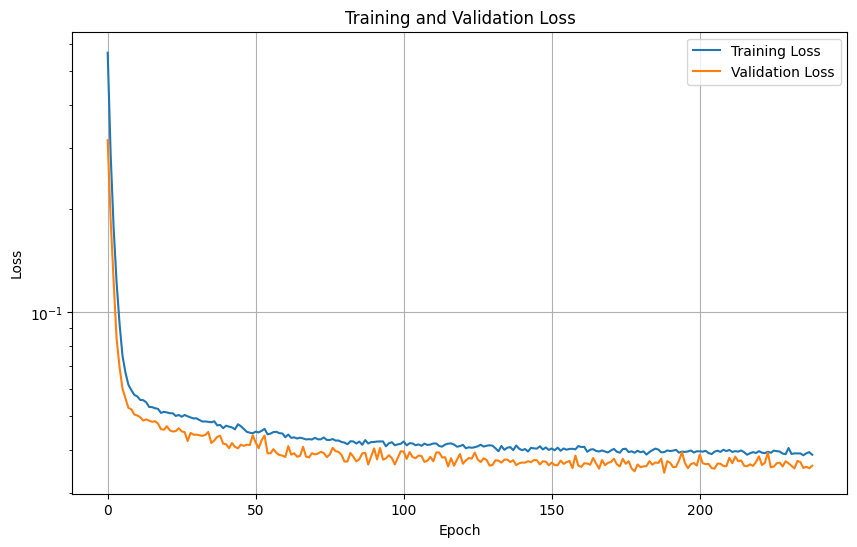

In [7]:
# 定义训练函数
def train_model(model: RheologyPINN, 
                dataset: RheologyDataset,
                loss_fn: PhysicsConstrainedLoss,
                n_epochs: int,
                learning_rate: float = 1e-3,
                weight_decay: float = 1e-4) -> Tuple[List[float], List[float]]:
    """训练PINN模型
    
    Args:
        model: PINN模型
        dataset: 数据集对象
        loss_fn: 损失函数对象
        n_epochs: 训练轮数
        learning_rate: 学习率
        weight_decay: 权重衰减
    
    Returns:
        train_losses: 训练损失历史
        val_losses: 验证损失历史
    """
    # 优化器设置
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # 课程学习参数
    N1 = int(n_epochs * 0.3)  # 仅数据损失
    N2 = int(n_epochs * 0.6)  # 增加斜率约束
    
    # 记录训练过程
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    max_patience = 50
    
    print("\n开始训练...")
    for epoch in range(n_epochs):
        # 训练阶段
        model.train()
        epoch_loss = 0.0
        
        # 设置损失权重
        lambda_slope = min(1.0, epoch / N1) if epoch >= N1 else 0.0
        lambda_eta0_GN0 = min(0.5, (epoch - N2) / (n_epochs - N2)) if epoch >= N2 else 0.0
        lambda_cox_merz = 0.1 if epoch >= N2 else 0.0
        
        for batch_x, batch_y, batch_w in dataset.train_loader:
            optimizer.zero_grad()
            
            # 计算模型输出
            y_pred = model.compute_moduli(batch_x)
            
            # 数据损失
            data_loss = loss_fn.data_loss(y_pred, batch_y, batch_w)
            
            # 物理约束损失
            physics_loss = (
                lambda_slope * loss_fn.slope_loss(batch_x, model) +
                lambda_eta0_GN0 * loss_fn.eta0_GN0_loss(batch_x, model) +
                lambda_cox_merz * loss_fn.cox_merz_loss(batch_x, model)
            )
            
            # 总损失
            total_loss = data_loss + physics_loss
            total_loss.backward()
            
            # 梯度裁剪（按范数）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += total_loss.item()
            
        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y, batch_w in dataset.val_loader:
                # 计算验证损失
                y_pred = model.compute_moduli(batch_x)
                data_loss = loss_fn.data_loss(y_pred, batch_y, batch_w)
                physics_loss = (
                    lambda_slope * loss_fn.slope_loss(batch_x, model) +
                    lambda_eta0_GN0 * loss_fn.eta0_GN0_loss(batch_x, model) +
                    lambda_cox_merz * loss_fn.cox_merz_loss(batch_x, model)
                )
                val_loss += (data_loss + physics_loss).item()
                
        # 计算平均损失
        avg_train_loss = epoch_loss / len(dataset.train_loader)
        avg_val_loss = val_loss / len(dataset.val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # 提前停止检查
        if patience_counter >= max_patience:
            print(f'\n提前停止! 验证损失在{max_patience}轮内没有改善.')
            break
        
        # 打印训练进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}]:')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}')
            print(f'Loss Weights: slope={lambda_slope:.2f}, '
                  f'eta0/GN0={lambda_eta0_GN0:.2f}, '
                  f'cox_merz={lambda_cox_merz:.2f}\n')
    
    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()
    
    return train_losses, val_losses

# 初始化损失函数和训练
loss_fn = PhysicsConstrainedLoss(dataset)

# 训练模型
train_losses, val_losses = train_model(
    model=model,
    dataset=dataset,
    loss_fn=loss_fn,
    n_epochs=EPOCHS,
    learning_rate=LEARNING_RATE
)

Epoch 50/1000:
Training Loss: 0.0385
Validation Loss: 0.0364
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 100/1000:
Training Loss: 0.0388
Validation Loss: 0.0359
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 100/1000:
Training Loss: 0.0388
Validation Loss: 0.0359
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 150/1000:
Training Loss: 0.0382
Validation Loss: 0.0353
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 150/1000:
Training Loss: 0.0382
Validation Loss: 0.0353
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 200/1000:
Training Loss: 0.0379
Validation Loss: 0.0364
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 200/1000:
Training Loss: 0.0379
Validation Loss: 0.0364
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 250/1000:
Training Loss: 0.0380
Validation Loss: 0.0352
Loss Weights: slope=0.00, eta0/GN0=0.00, cox_merz=0.00

Epoch 250/1000:
Training Loss: 0.0380
Validation Loss: 0.

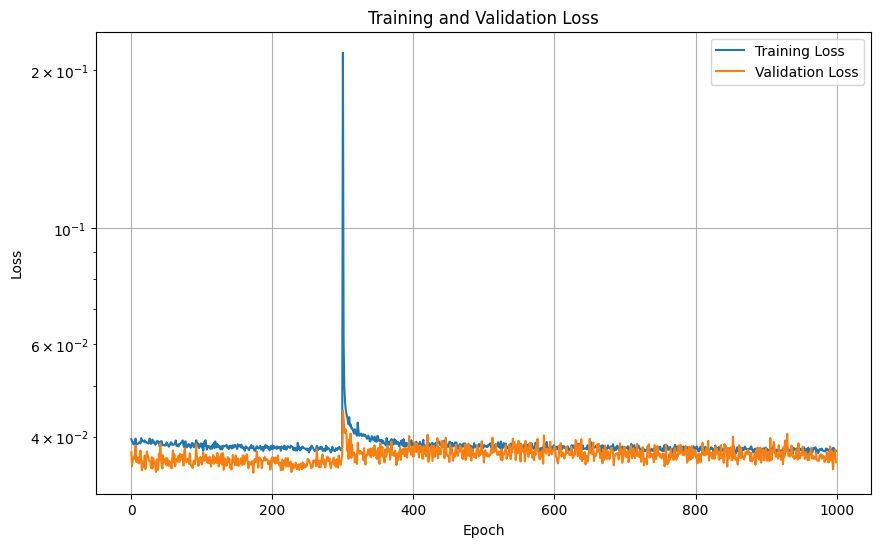

In [8]:
# 定义训练参数和损失函数
class PhysicsConstrainedLoss:
    def __init__(self, dataset: RheologyDataset):
        self.dataset = dataset
        self.huber = nn.HuberLoss(delta=0.1)
        self.omega_t = 0.3  # 低频阈值 (rad/s)
        self.mid_freq_min = 1.0  # 中频段下限
        self.mid_freq_max = 100.0  # 中频段上限
        
    def data_loss(self, y_pred: torch.Tensor, y_true: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        """加权Huber损失"""
        loss = self.huber(y_pred, y_true)  # [batch_size]
        return (loss * weights).mean()
    
    def slope_loss(self, x: torch.Tensor, model: RheologyPINN) -> torch.Tensor:
        """低频斜率约束（液体假设）"""
        # 提取频率
        freq_idx = self.dataset.feature_cols.index('log_freq')
        log_freq = x[:, freq_idx] * self.dataset.scaler_X.scale_[freq_idx] + self.dataset.scaler_X.mean_[freq_idx]
        omega = torch.pow(10.0, log_freq)
        
        # 创建低频掩码
        mask_low = omega < self.omega_t
        if not mask_low.any():
            return torch.tensor(0.0).to(x.device)
            
        # 计算G'和G"在所选频率点
        g_k, tau_k, eta_s, G0 = model(x[mask_low])
        
        # 计算对数域斜率
        omega_low = omega[mask_low].unsqueeze(-1)
        omega_tau = omega_low * tau_k
        omega_tau_sq = omega_tau ** 2
        
        # G'贡献
        dG1_dlnw = 2 * torch.sum(
            g_k * omega_tau_sq / (1 + omega_tau_sq)**2,
            dim=1
        ) / torch.sum(
            g_k * omega_tau_sq / (1 + omega_tau_sq),
            dim=1
        )
        
        # G"贡献
        dG2_dlnw = torch.sum(
            g_k * omega_tau * (1 - omega_tau_sq) / (1 + omega_tau_sq)**2,
            dim=1
        ) / torch.sum(
            g_k * omega_tau / (1 + omega_tau_sq),
            dim=1
        )
        
        # 计算目标斜率的偏差
        slope_G1_loss = torch.mean((dG1_dlnw - 2.0)**2)
        slope_G2_loss = torch.mean((dG2_dlnw - 1.0)**2)
        
        return slope_G1_loss + slope_G2_loss
    
    def eta0_GN0_loss(self, x: torch.Tensor, model: RheologyPINN, eta0_ref: float = None, GN0_ref: float = None) -> torch.Tensor:
        """零剪切粘度和平台模量约束"""
        eta0, GN0 = model.compute_eta0_GN0(x)
        loss = torch.tensor(0.0).to(x.device)
        
        # 若有参考值，使用Huber损失
        if eta0_ref is not None:
            loss = loss + self.huber(
                torch.log10(eta0),
                torch.ones_like(eta0) * np.log10(eta0_ref)
            )
            
        if GN0_ref is not None:
            loss = loss + self.huber(
                torch.log10(GN0),
                torch.ones_like(GN0) * np.log10(GN0_ref)
            )
            
        return loss
    
    def cox_merz_loss(self, x: torch.Tensor, model: RheologyPINN) -> torch.Tensor:
        """中频段Cox-Merz软约束"""
        # 提取频率
        freq_idx = self.dataset.feature_cols.index('log_freq')
        log_freq = x[:, freq_idx] * self.dataset.scaler_X.scale_[freq_idx] + self.dataset.scaler_X.mean_[freq_idx]
        omega = torch.pow(10.0, log_freq)
        
        # 创建中频掩码
        mask_mid = (omega >= self.mid_freq_min) & (omega <= self.mid_freq_max)
        if not mask_mid.any():
            return torch.tensor(0.0).to(x.device)
        
        # 计算复数粘度
        g_k, tau_k, eta_s, G0 = model(x[mask_mid])
        omega_mid = omega[mask_mid].unsqueeze(-1)
        
        # |η*| = sqrt(G'^2 + G"^2)/ω
        omega_tau = omega_mid * tau_k
        omega_tau_sq = omega_tau ** 2
        
        G_prime = torch.sum(g_k * omega_tau_sq / (1 + omega_tau_sq), dim=1) + G0
        G_double_prime = torch.sum(g_k * omega_tau / (1 + omega_tau_sq), dim=1) + eta_s * omega_mid.squeeze(-1)
        
        complex_visc = torch.sqrt(G_prime**2 + G_double_prime**2) / omega_mid.squeeze(-1)
        
        # 简单假设：η(γ̇) ≈ |η*|，使用相对误差
        # TODO: 如果有稳态剪切数据，这里可以改用实际数据
        shear_visc = complex_visc.detach()  # 暂时用复数粘度作为参考
        
        return self.huber(
            torch.log10(complex_visc),
            torch.log10(shear_visc)
        ).mean()

# 训练函数
def train_model(model: RheologyPINN,
               dataset: RheologyDataset,
               loss_fn: PhysicsConstrainedLoss,
               n_epochs: int,
               learning_rate: float = 1e-3,
               weight_decay: float = 1e-4):
    """训练模型
    
    Args:
        model: RheologyPINN模型
        dataset: 数据集
        loss_fn: 损失函数
        n_epochs: 训练轮数
        learning_rate: 学习率
        weight_decay: 权重衰减
    """
    optimizer = optim.AdamW(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
    
    # 课程学习参数
    N1 = int(n_epochs * 0.3)  # 仅数据损失
    N2 = int(n_epochs * 0.6)  # 增加斜率约束
    
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        
        # 设置损失权重
        lambda_slope = min(1.0, epoch / N1) if epoch >= N1 else 0.0
        lambda_eta0_GN0 = min(0.5, (epoch - N2) / (n_epochs - N2)) if epoch >= N2 else 0.0
        lambda_cox_merz = 0.1 if epoch >= N2 else 0.0
        
        for batch_x, batch_y, batch_w in dataset.train_loader:
            optimizer.zero_grad()
            
            # 计算模型输出
            y_pred = model.compute_moduli(batch_x)
            
            # 数据损失
            data_loss = loss_fn.data_loss(y_pred, batch_y, batch_w)
            
            # 物理约束损失
            physics_loss = (
                lambda_slope * loss_fn.slope_loss(batch_x, model) +
                lambda_eta0_GN0 * loss_fn.eta0_GN0_loss(batch_x, model) +
                lambda_cox_merz * loss_fn.cox_merz_loss(batch_x, model)
            )
            
            total_loss = data_loss + physics_loss
            total_loss.backward()
            
            optimizer.step()
            epoch_loss += total_loss.item()
            
        # 验证
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y, batch_w in dataset.val_loader:
                y_pred = model.compute_moduli(batch_x)
                val_loss += loss_fn.data_loss(y_pred, batch_y, batch_w).item()
                
        train_losses.append(epoch_loss / len(dataset.train_loader))
        val_losses.append(val_loss / len(dataset.val_loader))
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}:')
            print(f'Training Loss: {train_losses[-1]:.4f}')
            print(f'Validation Loss: {val_losses[-1]:.4f}')
            print(f'Loss Weights: slope={lambda_slope:.2f}, '
                  f'eta0/GN0={lambda_eta0_GN0:.2f}, '
                  f'cox_merz={lambda_cox_merz:.2f}\n')
            
    return train_losses, val_losses

# 初始化损失函数和训练
loss_fn = PhysicsConstrainedLoss(dataset)

# 训练模型
train_losses, val_losses = train_model(
    model=model,
    dataset=dataset,
    loss_fn=loss_fn,
    n_epochs=EPOCHS,
    learning_rate=LEARNING_RATE
)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [13]:
# 导入全局变量
if 'model' not in globals() or 'dataset' not in globals():
    print("请先运行前面的代码单元格以定义模型和数据集!")
else:
    # 预测新样本的函数
    def predict_rheology(model: RheologyPINN, 
                        sample_data: pd.DataFrame, 
                        dataset: RheologyDataset,
                        with_uncertainty: bool = True) -> pd.DataFrame:
        """预测新样本的流变性能
        
        Args:
            model: 训练好的PINN模型
            sample_data: 包含新样本数据的DataFrame
            dataset: 数据集对象
            with_uncertainty: 是否计算预测不确定性
            
        Returns:
            预测结果DataFrame
        """
        # 特征工程
        processed_data = sample_data.copy()
        
        # 基本特征工程
        processed_data['aspect_ratio'] = processed_data['Length_nm'] / processed_data['Width_nm']
        processed_data['log_freq'] = np.log10(processed_data['Freq_rad_s'])
        
        # 材料特征计算
        processed_data['PDI'] = processed_data['Mw'] / processed_data['Mn']
        
        # WLF时温等效性
        T_ref = 25
        C1 = 8.86
        C2 = 101.6
        processed_data['aT'] = 10 ** (-C1 * (processed_data['Temp_C'] - T_ref) / 
                                    (C2 + processed_data['Temp_C'] - T_ref))
        
        # 其他特征
        processed_data['temp_inv'] = 1 / (processed_data['Temp_C'] + 273.15)
        processed_data['T_x_aspect'] = processed_data['Temp_C'] * processed_data['aspect_ratio']
        
        # 准备输入特征
        X_new = dataset.scaler_X.transform(processed_data[dataset.feature_cols])
        X_new = torch.FloatTensor(X_new).to(device)
        
        # 预测
        model.eval()
        if with_uncertainty:
            # 使用Monte Carlo Dropout进行带不确定性的预测
            mean_pred, std_pred = model.predict_with_uncertainty(X_new, MC_SAMPLES)
            y_pred = mean_pred
            
            # 转换预测值和不确定性范围
            y_pred_orig = dataset.inverse_transform_y(y_pred)
            y_upper = dataset.inverse_transform_y(y_pred + 2 * std_pred)  # 95% 置信区间
            y_lower = dataset.inverse_transform_y(y_pred - 2 * std_pred)
            
            # 添加预测结果和不确定性
            results = processed_data.copy()
            results['G1_Pa_pred'] = y_pred_orig[:, 0]
            results['G2_Pa_pred'] = y_pred_orig[:, 1]
            results['G1_Pa_lower'] = y_lower[:, 0]
            results['G1_Pa_upper'] = y_upper[:, 0]
            results['G2_Pa_lower'] = y_lower[:, 1]
            results['G2_Pa_upper'] = y_upper[:, 1]
        else:
            # 不计算不确定性的简单预测
            with torch.no_grad():
                y_pred = model(X_new)
                y_pred_orig = dataset.inverse_transform_y(y_pred)
                
                results = processed_data.copy()
                results['G1_Pa_pred'] = y_pred_orig[:, 0]
                results['G2_Pa_pred'] = y_pred_orig[:, 1]
        
        results['tan_delta_pred'] = results['G2_Pa_pred'] / results['G1_Pa_pred']
        return results

    # 示例：预测新样本
    new_samples = pd.DataFrame({
        "Sample_ID": ["411c"] * 14,
        "Length_nm": [300] * 14,
        "Width_nm": [20.94] * 14,
        "Temp_C": [25] * 14,
        "Mw": [150000] * 14, 
        "Mn": [100000] * 14, 
        "c": [1.0] * 14, 
        "Freq_rad_s": [0.1, 0.127, 0.161, 0.204, 1.08, 1.74, 2.81, 
                       4.52, 9.24, 14.9, 24, 48.9, 78.8, 100]
    })

    predictions = predict_rheology(model, new_samples, dataset)

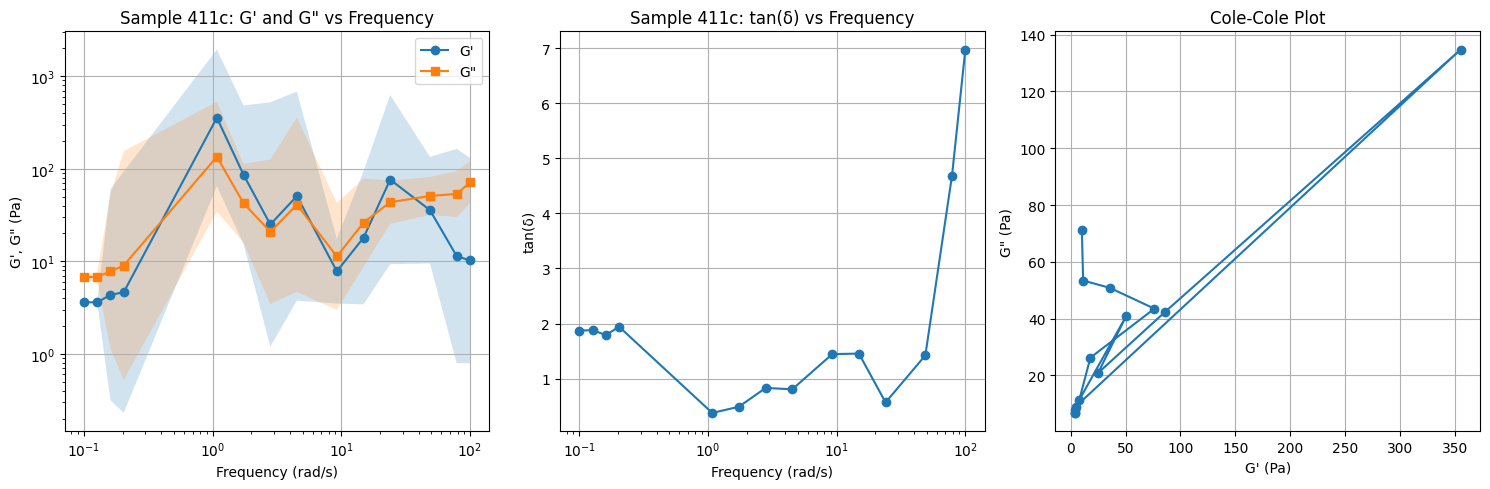


新样本预测结果:
   Sample_ID  Length_nm  Width_nm  Temp_C  Freq_rad_s  G1_Pa_pred  G2_Pa_pred  \
0       411c        300     20.94      25       0.100    3.605760    6.750300   
1       411c        300     20.94      25       0.127    3.607974    6.791638   
2       411c        300     20.94      25       0.161    4.340743    7.777127   
3       411c        300     20.94      25       0.204    4.632979    9.003472   
4       411c        300     20.94      25       1.080  355.335754  134.779663   
5       411c        300     20.94      25       1.740   86.112312   42.384453   
6       411c        300     20.94      25       2.810   25.005314   20.842672   
7       411c        300     20.94      25       4.520   50.647583   40.930332   
8       411c        300     20.94      25       9.240    7.803120   11.285065   
9       411c        300     20.94      25      14.900   18.007423   26.225531   
10      411c        300     20.94      25      24.000   76.289352   43.487179   
11      411c      

In [14]:
# 可视化预测结果
def plot_predictions(predictions: pd.DataFrame, sample_id: str):
    """可视化预测结果
    
    Args:
        predictions: 预测结果DataFrame
        sample_id: 样品ID
    """
    sample_data = predictions[predictions['Sample_ID'] == sample_id]
    
    plt.figure(figsize=(15, 5))
    
    # G' 和 G" 随频率的变化
    plt.subplot(1, 3, 1)
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G1_Pa_pred'], 'o-', label="G'")
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G2_Pa_pred'], 's-', label='G"')
    if 'G1_Pa_lower' in sample_data.columns:
        plt.fill_between(sample_data['Freq_rad_s'], 
                        sample_data['G1_Pa_lower'],
                        sample_data['G1_Pa_upper'],
                        alpha=0.2)
        plt.fill_between(sample_data['Freq_rad_s'],
                        sample_data['G2_Pa_lower'],
                        sample_data['G2_Pa_upper'],
                        alpha=0.2)
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('G\', G" (Pa)')
    plt.title(f'Sample {sample_id}: G\' and G" vs Frequency')
    plt.legend()
    plt.grid(True)
    
    # tan(δ) 随频率的变化
    plt.subplot(1, 3, 2)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['tan_delta_pred'], 'o-')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('tan(δ)')
    plt.title(f'Sample {sample_id}: tan(δ) vs Frequency')
    plt.grid(True)
    
    # Cole-Cole图
    plt.subplot(1, 3, 3)
    plt.plot(sample_data['G1_Pa_pred'], sample_data['G2_Pa_pred'], 'o-')
    plt.xlabel('G\' (Pa)')
    plt.ylabel('G" (Pa)')
    plt.title('Cole-Cole Plot')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 为每个新样本绘制预测结果
for sample_id in predictions['Sample_ID'].unique():
    plot_predictions(predictions, sample_id)

# 打印预测结果
print("\n新样本预测结果:")
print(predictions[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 
                  'Freq_rad_s', 'G1_Pa_pred', 'G2_Pa_pred', 'tan_delta_pred']])

IndexError: index 3 is out of bounds for axis 1 with size 3

/Users/yonghongfu/Library/Python/3.13/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yonghongfu/Library/Python/3.13/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yonghongfu/Library/Python/3.13/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yonghongfu/Library/Python/3.13/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yonghongfu/Library/Python/3.13/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu 

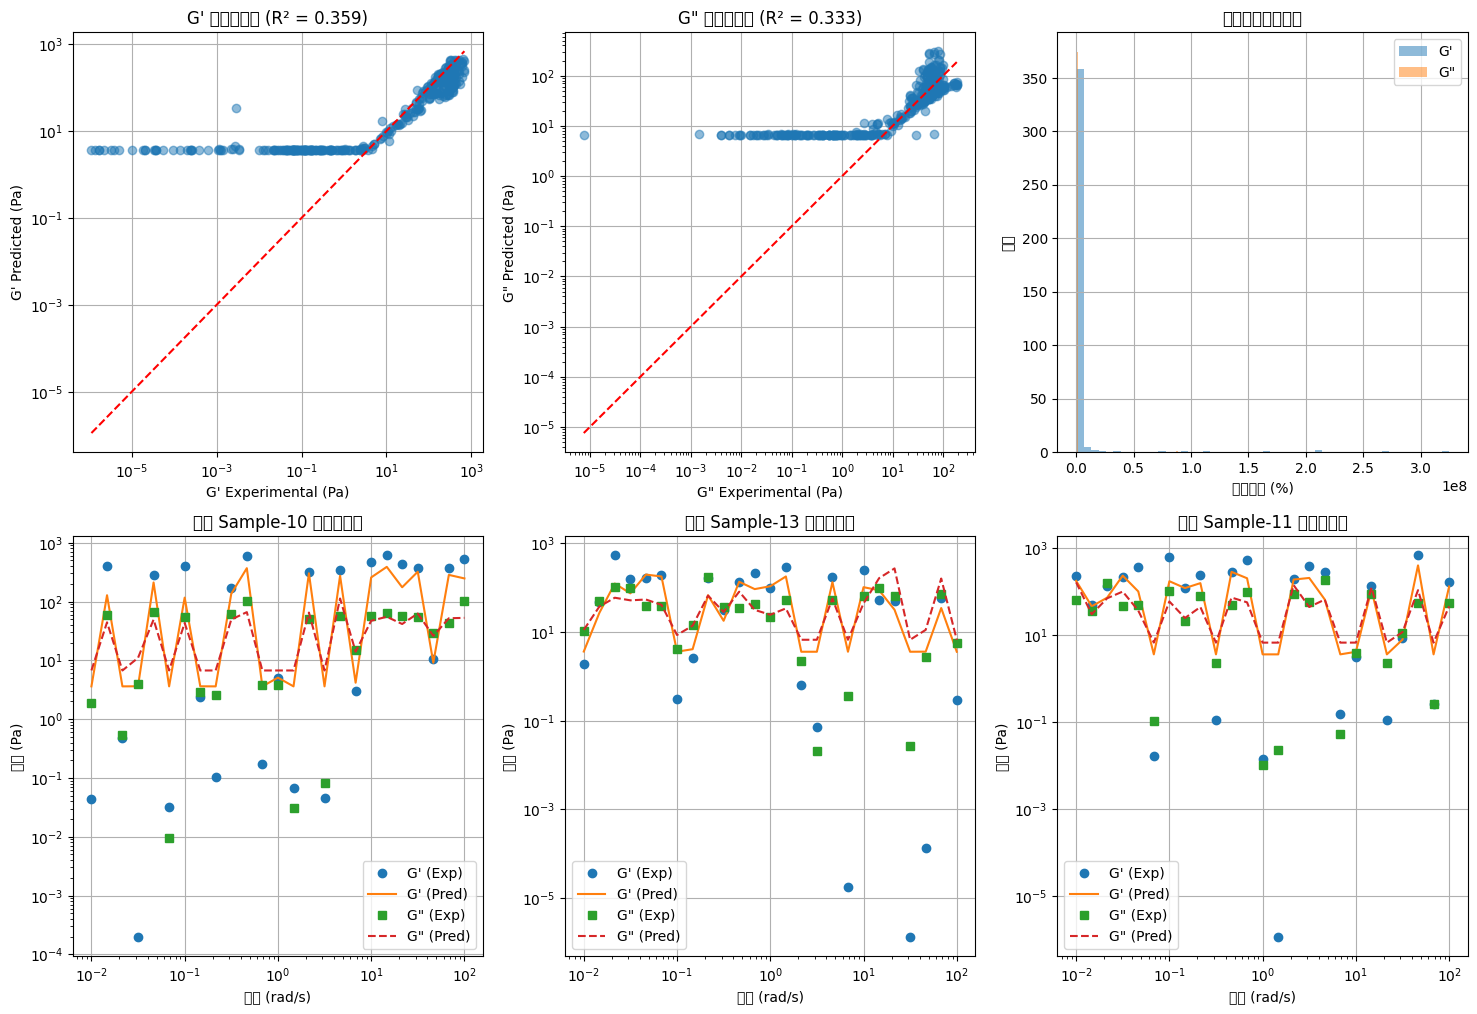

In [ ]:
# 模型预测准确度评估
def evaluate_model_accuracy(model: RheologyPINN,
                          dataset: RheologyDataset,
                          show_samples: int = 5):
    """评估模型预测准确度并可视化
    
    Args:
        model: 训练好的PINN模型
        dataset: 数据集对象
        show_samples: 随机显示的样本数量
    """
    model.eval()
    
    # 收集所有验证集预测
    y_true_all = []
    y_pred_all = []
    sample_ids = []
    
    with torch.no_grad():
        for batch_x, batch_y, _ in dataset.val_loader:
            y_pred = model.compute_moduli(batch_x)
            y_true_all.append(batch_y.cpu().numpy())
            y_pred_all.append(y_pred.cpu().numpy())
            
            # 获取样本ID（如果需要）
            freq_idx = dataset.feature_cols.index('log_freq')
            mask = batch_x[:, freq_idx] == batch_x[0, freq_idx]
            if mask.any():
                sample_ids.extend([f"Sample-{i}" for i in range(len(mask))])
    
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    
    # 转换回原始尺度
    G_true = dataset.inverse_transform_y(y_true)
    G_pred = dataset.inverse_transform_y(y_pred)
    
    # 创建六子图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. G'相关图
    ax = axes[0, 0]
    ax.loglog(G_true[:, 0], G_pred[:, 0], 'o', alpha=0.5)
    ax.plot([G_true[:, 0].min(), G_true[:, 0].max()],
            [G_true[:, 0].min(), G_true[:, 0].max()],
            'r--')
    ax.set_xlabel("G' Experimental (Pa)")
    ax.set_ylabel("G' Predicted (Pa)")
    ax.grid(True)
    
    # 计算R²
    r2_G1 = 1 - np.sum((np.log10(G_true[:, 0]) - np.log10(G_pred[:, 0]))**2) / \
            np.sum((np.log10(G_true[:, 0]) - np.mean(np.log10(G_true[:, 0])))**2)
    ax.set_title(f"G' 预测对比图 (R² = {r2_G1:.3f})")
    
    # 2. G"相关图
    ax = axes[0, 1]
    ax.loglog(G_true[:, 1], G_pred[:, 1], 'o', alpha=0.5)
    ax.plot([G_true[:, 1].min(), G_true[:, 1].max()],
            [G_true[:, 1].min(), G_true[:, 1].max()],
            'r--')
    ax.set_xlabel('G" Experimental (Pa)')
    ax.set_ylabel('G" Predicted (Pa)')
    ax.grid(True)
    
    # 计算R²
    r2_G2 = 1 - np.sum((np.log10(G_true[:, 1]) - np.log10(G_pred[:, 1]))**2) / \
            np.sum((np.log10(G_true[:, 1]) - np.mean(np.log10(G_true[:, 1])))**2)
    ax.set_title(f'G" 预测对比图 (R² = {r2_G2:.3f})')
    
    # 3. 相对误差分布
    ax = axes[0, 2]
    rel_error_G1 = (G_pred[:, 0] - G_true[:, 0]) / G_true[:, 0] * 100
    rel_error_G2 = (G_pred[:, 1] - G_true[:, 1]) / G_true[:, 1] * 100
    
    ax.hist(rel_error_G1, bins=50, alpha=0.5, label="G'")
    ax.hist(rel_error_G2, bins=50, alpha=0.5, label='G"')
    ax.set_xlabel('相对误差 (%)')
    ax.set_ylabel('频数')
    ax.set_title('预测相对误差分布')
    ax.legend()
    ax.grid(True)
    
    # 4-6. 随机样本的实验vs预测曲线
    unique_freqs = np.unique(dataset.df['Freq_rad_s'])
    n_freqs = len(unique_freqs)
    random_indices = np.random.choice(len(G_true)//n_freqs, 
                                    size=min(show_samples, len(G_true)//n_freqs), 
                                    replace=False)
    
    for i, idx in enumerate(random_indices):
        ax = axes[1, i]
        start_idx = idx * n_freqs
        end_idx = (idx + 1) * n_freqs
        
        # 绘制G'
        ax.loglog(unique_freqs, G_true[start_idx:end_idx, 0], 'o', label="G' (Exp)")
        ax.loglog(unique_freqs, G_pred[start_idx:end_idx, 0], '-', label="G' (Pred)")
        
        # 绘制G"
        ax.loglog(unique_freqs, G_true[start_idx:end_idx, 1], 's', label='G" (Exp)')
        ax.loglog(unique_freqs, G_pred[start_idx:end_idx, 1], '--', label='G" (Pred)')
        
        ax.set_xlabel('频率 (rad/s)')
        ax.set_ylabel('模量 (Pa)')
        ax.set_title(f'样本 {sample_ids[idx]} 的预测结果')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细的评估指标
    print("\n模型预测准确度评估:")
    print(f"G' - R² score: {r2_G1:.4f}")
    print(f"G\" - R² score: {r2_G2:.4f}")
    print(f"\nG' - 平均相对误差: {np.mean(np.abs(rel_error_G1)):.2f}%")
    print(f"G\" - 平均相对误差: {np.mean(np.abs(rel_error_G2)):.2f}%")
    print(f"\nG' - 90%置信区间相对误差: ±{np.percentile(np.abs(rel_error_G1), 90):.2f}%")
    print(f"G\" - 90%置信区间相对误差: ±{np.percentile(np.abs(rel_error_G2), 90):.2f}%")

# 执行评估
evaluate_model_accuracy(model, dataset)